# Quantitative Spatial Economics (Summer Term 2024)
Humboldt University Berlin & Berlin School of Economics
Ahlfeldt, Herrera & Marczinek

Authors:
[Dominik Bursy](mailto:dominik.bursy@icloud.com),
[Lars Felder](),
[Marlon Krippendorf]()

Last Update: April 2024

---

## Tutorial Topic 1: Rosen-Roback

Context: In Topic 1, we cover the Rosen-Roback framework during the lecture. In this tutorial, we apply the logic of the spatial equilibrium framework to compute a quality-of-life (QoL) ranking for Germany counties (Kreise & kreisfreie Städte).

---

## Table of Contents

- [Import Packages](#packages)
- [Import Datasets](#data_import)
- [1. Average Wage](#average_wage)
- [2. House Price Index](#house_price_index)
- [3. Exogenous Factors](#exogenous_factors)
- [Appendix](#appendix)

--- 

## References

- ...

---

## Import Packages <a class="anchor" id="packages"></a>

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS 

import requests, zipfile, io

# import warnings
# warnings.filterwarnings('ignore')

## Document Options
savefigures = False
# pd.set_option('display.max_columns', None)

In [2]:
## Set Root Directory

ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration


## Import Datasets <a class="anchor" id="data_import"></a>

In [3]:
## Shapefile of German Counties

gdf_germany_counties = gpd.read_file(f'{ROOT_FOLDER}/data/Shapefiles-2022/Germany/COUNTIES/VG250_KRS_clean_final.shp')
gdf_germany_counties = gdf_germany_counties[['county_id', 'GEN', 'EWZ', 'KFL', 'geometry']] 
gdf_germany_counties.rename(columns={'GEN': 'county_name', 'EWZ': 'population', 'KFL': 'county_area'}, inplace=True) 

In [4]:
## Shapefile of German State

url = 'https://daten.gdz.bkg.bund.de/produkte/vg/vg2500/aktuell/vg2500_12-31.utm32s.shape.zip'
filename = 'vg2500_12-31.utm32s.shape/vg2500/VG2500_LAN.shp'

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

gdf_germany_states = gpd.read_file(filename, sep=',')
gdf_germany_states = gdf_germany_states.loc[:,['GEN', 'geometry']].rename(columns={'GEN':'state_name'})
gdf_germany_states = gdf_germany_states.iloc[:16]

## Add State Information to German Counties 
# gdf_germany_counties = gdf_germany_counties.sjoin(gdf_germany_states).drop(['index_right'], axis=1)

In [5]:
## Points of German Cities

df_germany_cities = pd.read_csv('https://simplemaps.com/static/data/country-cities/de/de.csv')

gdf_germany_cities = gpd.GeoDataFrame(
    df_germany_cities, geometry=gpd.points_from_xy(df_germany_cities.lng, df_germany_cities.lat), crs="EPSG:4326"
).to_crs(25832)

gdf_germany_cities_large = gdf_germany_cities.iloc[:14,:]

In [6]:
## Wage and Employment data of the German Federal Employment Agency

df_wages = pd.read_excel(f'{ROOT_FOLDER}/data/county-wages-2022/country-wages-2022-entgelt-dwolk-0-202212-xlsx (1).xlsx',
              sheet_name='8.1', header=9)

## Task 1: Wage and Employment across Germany <a class="anchor" id="average_wage"></a>

In [7]:
## Wage and Employment data of the German Federal Employment Agency

df_wages = pd.read_excel(f'{ROOT_FOLDER}/data/county-wages-2022/country-wages-2022-entgelt-dwolk-0-202212-xlsx (1).xlsx',
              sheet_name='8.1', header=9)

## Extract wages and number of workers for workers 

# i) without professional qualification(ohne Berufsabschluss)
gdf_germany_counties = gdf_germany_counties.join(
    df_wages.loc[df_wages['Unnamed: 2'] == 'ohne Berufsabschluss', ['Unnamed: 0', 1, 8]].set_index('Unnamed: 0'), 
    on='county_id').rename(columns={1: 'workers_no_qualification', 8: 'wage_no_qualification'})

# ii)with recognized professional qualification (anerkannter Berufsabschluss)
gdf_germany_counties = gdf_germany_counties.join(
    df_wages.loc[df_wages['Unnamed: 2'] == 'anerkannter Berufsabschluss', ['Unnamed: 0', 1, 8]].set_index('Unnamed: 0'), 
    on='county_id').rename(columns={1: 'workers_professional', 8: 'wage_professional'})

# iii) with academic degree (akademischer Berufsabschluss)
gdf_germany_counties = gdf_germany_counties.join(
    df_wages.loc[df_wages['Unnamed: 2'] == 'akademischer Berufsabschluss', ['Unnamed: 0', 1, 8]].set_index('Unnamed: 0'), 
    on='county_id').rename(columns={1: 'workers_academic', 8: 'wage_academic'})

## Clean Wage and Employment data

gdf_germany_counties.replace('X', np.nan, inplace=True)
gdf_germany_counties.replace('> 7.050', 7050, inplace=True)
gdf_germany_counties.iloc[:,5:] = gdf_germany_counties.iloc[:,5:].astype('float')

## Create lists of Skill Groups

list_workers_skill_groups = ['workers_no_qualification', 'workers_professional', 'workers_academic']
list_wage_skill_groups = ['wage_no_qualification', 'wage_professional', 'wage_academic']

### Descriptive Statistics Employment across Germany

In [8]:
print(tabulate(
    gdf_germany_counties[list_workers_skill_groups].describe(),
    headers=['Workers', 'No Qualification', 'Professional', 'Academic'], tablefmt='orgtbl'))

| Workers   |   No Qualification |   Professional |   Academic |
|-----------+--------------------+----------------+------------|
| count     |             400    |          400   |      400   |
| mean      |            4651.64 |        34476.9 |    11531.5 |
| std       |            6485.95 |        39289.4 |    29205.1 |
| min       |             354    |         5092   |      641   |
| 25%       |            1732.75 |        16472   |     2690   |
| 50%       |            2848    |        24859   |     4755.5 |
| 75%       |            5459.5  |        38817.8 |     9950.5 |
| max       |           73456    |       475713   |   360929   |


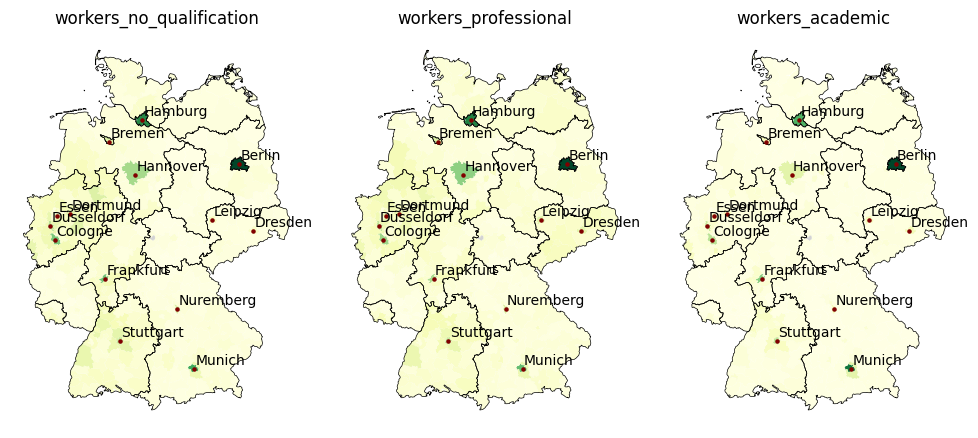

In [9]:
figure, axis = plt.subplots(1, 3, figsize=(10, 10)) 

for skill_group in list_workers_skill_groups:
    axis_index = list_workers_skill_groups.index(skill_group)
    gdf_germany_counties.plot(column=skill_group, cmap='YlGn', ax=axis[axis_index], 
                              missing_kwds={"color": "lightgrey", "label": "Missing values"})
    gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis[axis_index])
    gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis[axis_index])

    for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
        ax=axis[axis_index].annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)
    
    ax=axis[axis_index].set_title(skill_group)
    ax=axis[axis_index].set_axis_off()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/germany_employment.png', bbox_inches='tight')
else:
    plt.tight_layout()

### Descriptive Statistics Wages across Germany

In [10]:
print(tabulate(
    gdf_germany_counties[list_wage_skill_groups].describe(),
    headers=['Wages', 'No Qualification', 'Professional', 'Academic'], tablefmt='orgtbl'))

| Wages   |   No Qualification |   Professional |   Academic |
|---------+--------------------+----------------+------------|
| count   |            396     |        400     |    400     |
| mean    |           2627.04  |       3436.1   |   5178.3   |
| std     |            238.413 |        377.625 |    581.128 |
| min     |           2145.27  |       2576.14  |   4044.25  |
| 25%     |           2470.09  |       3254.59  |   4736.78  |
| 50%     |           2635.93  |       3460.88  |   5089.03  |
| 75%     |           2776.48  |       3648.54  |   5469.77  |
| max     |           3378.25  |       4908.91  |   7050     |


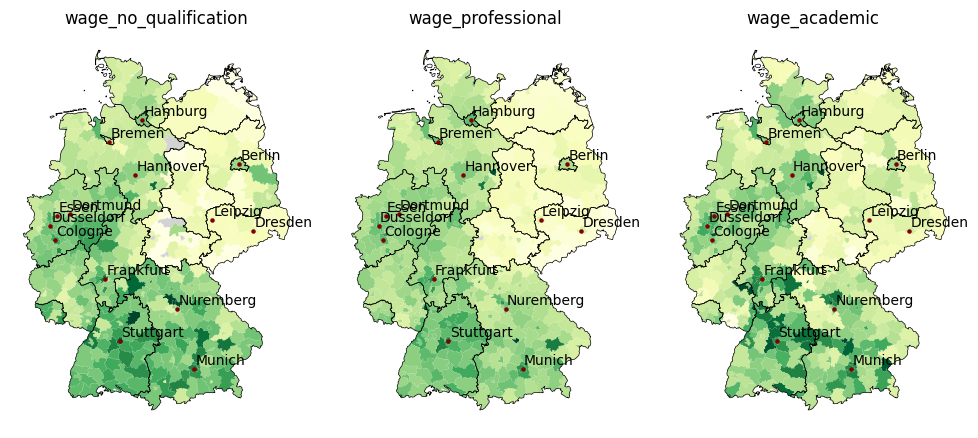

In [11]:
figure, axis = plt.subplots(1, 3, figsize=(10, 10)) 

for skill_group in list_wage_skill_groups:
    axis_index = list_wage_skill_groups.index(skill_group)
    gdf_germany_counties.plot(column=skill_group, cmap='YlGn', ax=axis[axis_index],
                              missing_kwds={"color": "lightgrey", "label": "Missing values"})
    gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis[axis_index])
    gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis[axis_index])

    for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
        ax=axis[axis_index].annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)
    
    ax=axis[axis_index].set_title(skill_group)
    ax=axis[axis_index].set_axis_off()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/germany_wages.png', bbox_inches='tight')
else:
    plt.tight_layout()

---

## Task 2: Mix-Adjusted House Price Index <a class="anchor" id="house_price_index"></a>

In [12]:
## Load the RWI-FDZ cross-section data on rental prices and purchase prices
df_campus_wm = pd.read_csv(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/cross_section/CampusFile_WM_2022.csv', low_memory=False)

## Inspect the data set
df_campus_wm.head()

,obid,plz,mietekalt,nebenkosten,heizkosten,baujahr,letzte_modernisierung,wohnflaeche,nutzflaeche,etage,...,bef3,anbieter,hits_gen,click_schnellkontakte_gen,click_weitersagen_gen,click_url_gen,liste_show_gen,liste_match_gen,adat,rent_sqm
0,134064657,24937,455.0,111,Other missing,NaN,Other missing,63.000000,Other missing,0,...,Other missing,Private offer,0.00000,0.000000,0.000000,0.000000,0.0000,0.0000,2022m5,7.222222
1,138475785,24937,380.0,85,95,NaN,Other missing,58.369999,Other missing,1,...,Other missing,Housing industry,65.25000,1.750000,0.000000,0.000000,1185.3125,3966.5625,2022m12,6.510194
2,136775842,24943,460.0,95,110,1980.0,Other missing,59.000000,Other missing,1,...,Other missing,Real-estate agent,108.94118,4.294117,0.000000,0.176471,1746.0588,4761.0000,2022m9,7.796610
3,91272177,24937,726.0,160,160,NaN,Other missing,80.650002,30,2,...,Other missing,Housing industry,968.23938,10.207627,0.099576,0.830508,19213.1190,59511.5040,2022m6,9.001860
4,138300121,24941,440.0,210,105,1955.0,Other missing,57.049999,Other missing,1,...,Other missing,Builder,110.06667,5.066667,0.000000,0.000000,1684.8667,4382.2002,2022m12,7.712533


In [15]:
## Select and prepare relevant characteristics 
df_campus_wm_clean = df_campus_wm.copy(deep=True)

# Year of construction 
df_campus_wm_clean.loc[df_campus_wm_clean['baujahr'].isna(), 'baujahr'] = df_campus_wm_clean['baujahr'].median()

# Number of Floor
df_campus_wm_clean.loc[df_campus_wm_clean['etage'] == 'Other missing', 'etage'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['etage'] == 'Implausible value', 'etage'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['etage'] == '44141.0', 'etage'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['etage'].isna()] = df_campus_wm_clean['etage'].median()
df_campus_wm_clean['etage'] = df_campus_wm_clean['etage'].astype(float)
df_campus_wm_clean['etage_squared'] = df_campus_wm_clean['etage']**2

# Number of Rooms
df_campus_wm_clean.loc[df_campus_wm_clean['zimmeranzahl'] == 'Implausible value', 'zimmeranzahl'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['zimmeranzahl'].isna(), 'zimmeranzahl'] = df_campus_wm_clean['zimmeranzahl'].median()
df_campus_wm_clean['zimmeranzahl'] = df_campus_wm_clean['zimmeranzahl'].astype(float)
df_campus_wm_clean['zimmeranzahl_squared'] = df_campus_wm_clean['zimmeranzahl']**2

# Postal Code
df_campus_wm_clean.loc[df_campus_wm_clean['plz'] == 'Other missing', 'plz'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['plz'].isna(), 'plz'] = df_campus_wm_clean['plz'].median()
df_campus_wm_clean['plz'] = df_campus_wm_clean['plz'].astype(float)

## Balcony
df_campus_wm_clean.loc[df_campus_wm_clean['balkon'] == 'Other missing', 'balkon'] = np.nan
df_campus_wm_clean['balkon'] = pd.get_dummies(df_campus_wm_clean['balkon'], drop_first=True)['Yes']

## Built-in Kitchen
df_campus_wm_clean.loc[df_campus_wm_clean['einbaukueche'] == 'Other missing', 'einbaukueche'] = np.nan
df_campus_wm_clean['einbaukueche'] = pd.get_dummies(df_campus_wm_clean['einbaukueche'], drop_first=True)['Yes']

## Parking Lot
df_campus_wm_clean.loc[df_campus_wm_clean['parkplatz'] == 'Other missing', 'parkplatz'] = np.nan
df_campus_wm_clean['parkplatz'] = pd.get_dummies(df_campus_wm_clean['parkplatz'], drop_first=True)['Yes']

## Elevator
df_campus_wm_clean.loc[df_campus_wm_clean['aufzug'] == 'Other missing', 'aufzug'] = np.nan
df_campus_wm_clean['aufzug'] = pd.get_dummies(df_campus_wm_clean['aufzug'], drop_first=True)['Yes']

In [16]:
## Set target, features and fixed effects

target = ['rent_sqm'] # Rent per square-meter: mietekalt / wohnflaeche
features = ['baujahr', 'etage', 'zimmeranzahl', 'einbaukueche', 'parkplatz', 'aufzug']
fixed_effects = ['kid2019']

## Subset dataframe, drop missing values and index as panel dataset
data_regression = df_campus_wm_clean[target + features + fixed_effects]
data_regression = data_regression.set_index(fixed_effects + [data_regression.index])

## Set dependent and explainatory variables 
Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

## Estimation of the firm fixed effects model
panel_ols_model = PanelOLS(Y, X, entity_effects=True, time_effects=False)
results_panel_ols_model = panel_ols_model.fit()
print(results_panel_ols_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:               rent_sqm   R-squared:                        0.1198
Estimator:                   PanelOLS   R-squared (Between):             -0.3555
No. Observations:              371103   R-squared (Within):               0.1198
Date:                Wed, Apr 23 2025   R-squared (Overall):              0.3121
Time:                        16:57:59   Log-likelihood                -8.142e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8411.2
Entities:                         381   P-value                           0.0000
Avg Obs:                       974.02   Distribution:                F(6,370716)
Min Obs:                       23.000                                           
Max Obs:                    6.079e+04   F-statistic (robust):             8411.2
                            

In [17]:
## Retrieve coefficients of firm fixed effects
df_fixed_effects = results_panel_ols_model.estimated_effects.reset_index().drop(columns='time').drop_duplicates(subset=['kid2019'])
df_fixed_effects['kid2019'] = df_fixed_effects['kid2019'].astype('object')

df_fixed_effects.rename(columns={'estimated_effects': 'rent_index'}, inplace=True)

gdf_germany_counties['county_id'] = gdf_germany_counties['county_id'].astype('float')
gdf_germany_counties = gdf_germany_counties.join(df_fixed_effects.set_index('kid2019'), on='county_id')

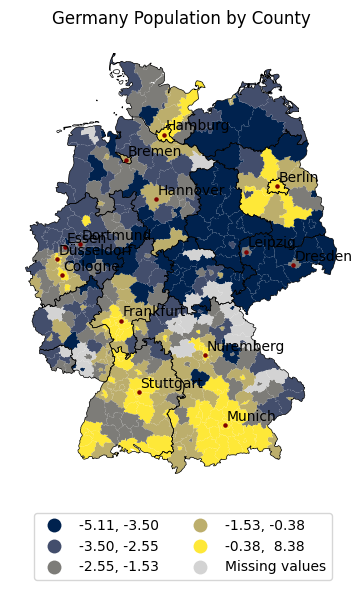

In [18]:
figure, axis = plt.subplots(1, 1, figsize=(5, 6)) 

gdf_germany_counties.plot(column='rent_index', cmap='cividis',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          scheme="quantiles", legend=True, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          ncol=2))

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Germany Population by County')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/rent_index.png', bbox_inches='tight')
else:
    plt.tight_layout()

---

In [19]:
df_campus_wk = pd.read_csv(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/cross_section/CampusFile_WK_2022.csv', low_memory=False)

In [20]:
## Select and prepare relevant characteristics 
df_campus_clean = df_campus_wk.copy(deep=True)

# Year of construction 
df_campus_clean.loc[df_campus_clean['baujahr'].isna(), 'baujahr'] = df_campus_clean['baujahr'].median()

# Number of Floor
df_campus_clean.loc[df_campus_clean['etage'] == 'Other missing', 'etage'] = np.nan
df_campus_clean.loc[df_campus_clean['etage'] == 'Implausible value', 'etage'] = np.nan
df_campus_clean.loc[df_campus_clean['etage'] == '44141.0', 'etage'] = np.nan
df_campus_clean.loc[df_campus_clean['etage'].isna()] = df_campus_clean['etage'].median()
df_campus_clean['etage'] = df_campus_clean['etage'].astype(float)
df_campus_clean['etage_squared'] = df_campus_clean['etage']**2

# Number of Rooms
df_campus_clean.loc[df_campus_clean['zimmeranzahl'] == 'Implausible value', 'zimmeranzahl'] = np.nan
df_campus_clean.loc[df_campus_clean['zimmeranzahl'].isna(), 'zimmeranzahl'] = df_campus_clean['zimmeranzahl'].median()
df_campus_clean['zimmeranzahl'] = df_campus_clean['zimmeranzahl'].astype(float)
df_campus_clean['zimmeranzahl_squared'] = df_campus_clean['zimmeranzahl']**2

# Postal Code
df_campus_clean.loc[df_campus_clean['plz'] == 'Other missing', 'plz'] = np.nan
df_campus_clean.loc[df_campus_clean['plz'].isna(), 'plz'] = df_campus_clean['plz'].median()
df_campus_clean['plz'] = df_campus_clean['plz'].astype(float)

## Balcony
df_campus_clean.loc[df_campus_clean['balkon'] == 'Other missing', 'balkon'] = np.nan
df_campus_clean['balkon'] = pd.get_dummies(df_campus_clean['balkon'], drop_first=True)['Yes']

## Built-in Kitchen
df_campus_clean.loc[df_campus_clean['einbaukueche'] == 'Other missing', 'einbaukueche'] = np.nan
df_campus_clean['einbaukueche'] = pd.get_dummies(df_campus_clean['einbaukueche'], drop_first=True)['Yes']

## Parking Lot
df_campus_clean.loc[df_campus_clean['parkplatz'] == 'Other missing', 'parkplatz'] = np.nan
df_campus_clean['parkplatz'] = pd.get_dummies(df_campus_clean['parkplatz'], drop_first=True)['Yes']

## Elevator
df_campus_clean.loc[df_campus_clean['aufzug'] == 'Other missing', 'aufzug'] = np.nan
df_campus_clean['aufzug'] = pd.get_dummies(df_campus_clean['aufzug'], drop_first=True)['Yes']

In [21]:
## Set target, features and fixed effects

target = ['price_sqm'] # Rent per square-meter: mietekalt / wohnflaeche
features = ['baujahr', 'etage', 'zimmeranzahl', 'einbaukueche', 'parkplatz', 'aufzug']
fixed_effects = ['kid2019']

## Subset dataframe, drop missing values and index as panel dataset
data_regression = df_campus_clean[target + features + fixed_effects]
data_regression = data_regression.set_index(fixed_effects + [data_regression.index])

## Set dependent and explainatory variables 
Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

## Estimation of the firm fixed effects model
panel_ols_model = PanelOLS(Y, X, entity_effects=True, time_effects=False)
results_panel_ols_model = panel_ols_model.fit()
print(results_panel_ols_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:              price_sqm   R-squared:                        0.0951
Estimator:                   PanelOLS   R-squared (Between):             -7.6768
No. Observations:              149747   R-squared (Within):               0.0951
Date:                Wed, Apr 23 2025   R-squared (Overall):             -1.2477
Time:                        16:58:56   Log-likelihood                -1.254e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2616.1
Entities:                         328   P-value                           0.0000
Avg Obs:                       456.55   Distribution:                F(6,149413)
Min Obs:                       16.000                                           
Max Obs:                    4.969e+04   F-statistic (robust):             2616.1
                            

In [22]:
## Retrieve coefficients of firm fixed effects
df_fixed_effects = results_panel_ols_model.estimated_effects.reset_index().drop(columns='time').drop_duplicates(subset=['kid2019'])
df_fixed_effects['kid2019'] = df_fixed_effects['kid2019'].astype('object')

df_fixed_effects.rename(columns={'estimated_effects': 'purchase_index'}, inplace=True)

gdf_germany_counties['county_id'] = gdf_germany_counties['county_id'].astype('float')
gdf_germany_counties = gdf_germany_counties.join(df_fixed_effects.set_index('kid2019'), on='county_id')

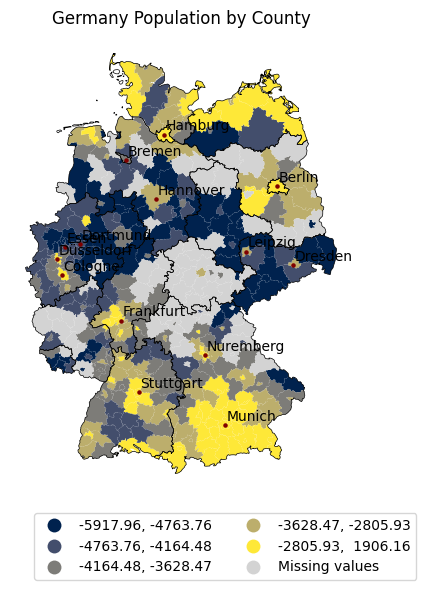

In [25]:
figure, axis = plt.subplots(1, 1, figsize=(5, 6)) 

gdf_germany_counties.plot(column='purchase_index', cmap='cividis',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          scheme="quantiles", legend=True, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          ncol=2))

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Germany Population by County')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/rent_index.png', bbox_inches='tight')
else:
    plt.tight_layout()

---

[GitHub Repo](#https://github.com/Ahlfeldt/AHS2023-toolkit/tree/main/APPLICATIONS/DATA/OUTPUT)

In [26]:
# df_ahs_purchase = pd.read_csv('https://raw.githubusercontent.com/Ahlfeldt/AHS2023-toolkit/refs/heads/main/APPLICATIONS/DATA/OUTPUT/2024/AHS-Index-GEM2021-2024/AHS-Index-PURCH-GEM2021-2024.csv')
# df_ahs_rent = pd.read_csv('https://raw.githubusercontent.com/Ahlfeldt/AHS2023-toolkit/refs/heads/main/APPLICATIONS/DATA/OUTPUT/2024/AHS-Index-GEM2021-2024/AHS-Index-RENT-GEM2021-2024.csv')

# df_ahs_purchase 
# df_ahs_rent

In [27]:
pd.read_csv('/Users/dominik.bursy/Downloads/__AHS_INDEX_public/APPLICATIONS/DATA/OUTPUT/INDEX_AHL_IMMO_county_RENT.csv')

,county_id,rprice_qm2007,rprice_qm_se2007,rcv2007,rprice_qm2008,rprice_qm_se2008,rcv2008,rprice_qm2009,rprice_qm_se2009,rcv2009,...,rcv2018,rprice_qm2019,rprice_qm_se2019,rcv2019,rprice_qm2020,rprice_qm_se2020,rcv2020,rprice_qm2021,rprice_qm_se2021,rcv2021
0,1001,5.158563,0.034024,0.006596,5.427319,0.032492,0.005987,5.630701,0.063126,0.011211,...,0.001551,7.975372,0.019391,0.002431,8.281983,0.006535,0.000789,8.340926,0.003655,0.000438
1,1002,5.848414,0.238018,0.040698,6.226290,0.143963,0.023122,6.394260,0.096883,0.015152,...,0.017577,8.805760,0.179367,0.020369,9.000280,0.160216,0.017801,9.379965,0.181972,0.019400
2,1003,6.071169,0.047501,0.007824,6.211424,0.066949,0.010778,6.281182,0.069765,0.011107,...,0.001175,8.808453,0.015881,0.001803,9.176073,0.027727,0.003022,9.598424,0.001107,0.000115
3,1004,5.210548,0.069873,0.013410,5.132879,0.066815,0.013017,5.199446,0.053658,0.010320,...,0.009784,7.065277,0.074002,0.010474,7.073081,0.043542,0.006156,7.590105,0.023713,0.003124
4,1051,4.999244,0.160650,0.032135,4.982765,0.144634,0.029027,5.048701,0.148650,0.029443,...,0.006409,6.477737,0.014130,0.002181,6.669360,0.286266,0.042923,7.243746,0.307527,0.042454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,16073,5.348390,0.697377,0.130390,5.347111,0.433711,0.081111,5.119702,0.404390,0.078987,...,0.079498,6.982438,0.938665,0.134432,6.885522,0.615293,0.089360,7.417726,0.340552,0.045911
397,16074,7.797028,1.950370,0.250143,7.056557,1.853600,0.262678,7.212421,2.255766,0.312761,...,0.329074,9.251781,3.384360,0.365806,8.435214,2.394459,0.283865,8.414023,2.898665,0.344504
398,16075,4.015102,0.027142,0.006760,3.827429,0.217137,0.056732,4.421989,0.026378,0.005965,...,0.120855,7.297518,0.882643,0.120951,7.142878,1.263895,0.176945,6.173117,1.808418,0.292951
399,16076,3.847743,0.134633,0.034990,4.032910,0.193580,0.048000,4.046927,0.152431,0.037666,...,0.040563,4.500445,0.182438,0.040538,4.654536,0.215353,0.046267,4.648874,0.244083,0.052504


---

## 3. Exogenous Factors <a class="anchor" id="exogenous_factors"></a>

Refer to the quantitative framework based on Glaeser & Gottlieb (2009) introduced in the lecture.


- (a) Quality-of-life index

    Create a theory-consistent QoL index, Bc. Assume an expenditure share of housing of one-third in the baseline. Map the QoL index for all combinations of skill groups and price indices. Compute QoL rankings by skill groups and check for any interesting apparent patterns, regularities, and inconsistencies across groups and price indices. A county shapefile can be found here: Data/Shapefiles-2022/Germany/COUNTIES.

- (b) Fundamental productivity

    Create a theory-consistent fundamental productivity index, Ac. Assume an input share of labour of two-thirds. Hint: You will need to run some regression to recover the input share of capital. Map the productivity index and discuss the spatial pattern.

- (c) Effective land supply

    Create a theory-consistent measure of effective land supply, Mc. Assume a height elasticity of construction cost of 1.5. Map the land supply measure and discuss the spatial pattern. Bonus question: Can you think of a theory-consistent way of estimating the height elasticity of construction cost?

---

$$
log(B_c) = \Omega_3 + \sigma log(P_c) - log(w_c) | Assume \Omega_3 is fixed, hence equal to 1.
$$


$$
B_c = \exp( \frac{P_c^{\sigma}}{w_c})
$$

In [30]:
expenditure_share = 1/3

gdf_germany_counties['rent_index'] = (gdf_germany_counties['rent_index']-gdf_germany_counties['rent_index'].min())/(gdf_germany_counties['rent_index'].max()-gdf_germany_counties['rent_index'].min())

gdf_germany_counties['qol_rent_no_qualification'] = np.exp(gdf_germany_counties['rent_index'] ** expenditure_share/ gdf_germany_counties['workers_no_qualification'])
gdf_germany_counties['qol_rent_professional'] = np.exp(gdf_germany_counties['rent_index'] ** expenditure_share/ gdf_germany_counties['workers_professional'])
gdf_germany_counties['qol_rent_academic'] = np.exp(gdf_germany_counties['rent_index'] ** expenditure_share/ gdf_germany_counties['workers_academic'])

gdf_germany_counties['purchase_index'] = (gdf_germany_counties['purchase_index']-gdf_germany_counties['purchase_index'].min())/(gdf_germany_counties['purchase_index'].max()-gdf_germany_counties['purchase_index'].min())

gdf_germany_counties['qol_purchase_no_qualification'] = np.exp(gdf_germany_counties['purchase_index'] ** expenditure_share/ gdf_germany_counties['workers_no_qualification'])
gdf_germany_counties['qol_purchase_professional'] = np.exp(gdf_germany_counties['purchase_index'] ** expenditure_share/ gdf_germany_counties['workers_professional'])
gdf_germany_counties['qol_purchase_academic'] = np.exp(gdf_germany_counties['purchase_index'] ** expenditure_share/ gdf_germany_counties['workers_academic'])

## Get ranking by sorting and reseting the index

In [31]:
from tabulate import tabulate

print(tabulate(
    pd.concat([
        gdf_germany_counties.sort_values('qol_rent_no_qualification', ascending=False)[['county_name']].reset_index(drop=True).head(10),
        gdf_germany_counties.sort_values('qol_rent_professional', ascending=False)[['county_name']].reset_index(drop=True).head(10),
        gdf_germany_counties.sort_values('qol_rent_academic', ascending=False)[['county_name']].reset_index(drop=True).head(10)], axis=1).values,
    headers=['No Qualification', 'Professional', 'Academic'], tablefmt='orgtbl'))

| No Qualification           | Professional               | Academic                   |
|----------------------------+----------------------------+----------------------------|
| Weimar                     | Neustadt an der Weinstraße | Cochem-Zell                |
| Neustadt an der Weinstraße | Schwabach                  | Schwabach                  |
| Suhl                       | Kaufbeuren                 | Neustadt an der Weinstraße |
| Brandenburg an der Havel   | Frankenthal (Pfalz)        | Kaufbeuren                 |
| Weimarer Land              | Cochem-Zell                | Delmenhorst                |
| Cochem-Zell                | Landau in der Pfalz        | Fürth                      |
| Wolfenbüttel               | Delmenhorst                | Freyung-Grafenau           |
| Frankfurt (Oder)           | Weimar                     | Bayreuth                   |
| Elbe-Elster                | Garmisch-Partenkirchen     | Kronach                    |
| Sömmerda           

In [33]:
print(tabulate(
    pd.concat([
        gdf_germany_counties.sort_values('qol_purchase_no_qualification', ascending=False)[['county_name']].reset_index(drop=True).head(10),
        gdf_germany_counties.sort_values('qol_purchase_professional', ascending=False)[['county_name']].reset_index(drop=True).head(10),
        gdf_germany_counties.sort_values('qol_purchase_academic', ascending=False)[['county_name']].reset_index(drop=True).head(10)], axis=1).values,
    headers=['No Qualification', 'Professional', 'Academic'], tablefmt='orgtbl'))

| No Qualification           | Professional               | Academic                   |
|----------------------------+----------------------------+----------------------------|
| Weimar                     | Wittmund                   | Wittmund                   |
| Wittmund                   | Neustadt an der Weinstraße | Schwabach                  |
| Neustadt an der Weinstraße | Schwabach                  | Neustadt an der Weinstraße |
| Garmisch-Partenkirchen     | Kaufbeuren                 | Kaufbeuren                 |
| Kaufbeuren                 | Frankenthal (Pfalz)        | Bayreuth                   |
| Friesland                  | Garmisch-Partenkirchen     | Fürth                      |
| Rosenheim                  | Weimar                     | Delmenhorst                |
| Wolfenbüttel               | Landau in der Pfalz        | Plön                       |
| Nordwestmecklenburg        | Fürth                      | Friesland                  |
| Miesbach           

In [34]:
gdf_germany_counties.sort_values('qol_purchase_no_qualification', ascending=False).loc[gdf_germany_counties['county_name'] == 'München']

,county_id,county_name,population,county_area,geometry,workers_no_qualification,wage_no_qualification,workers_professional,wage_professional,workers_academic,wage_academic,rent_index,purchase_index,qol_rent_no_qualification,qol_rent_professional,qol_rent_academic,qol_purchase_no_qualification,qol_purchase_professional,qol_purchase_academic
238,9184.0,München,350473.0,664.26,"POLYGON ((691855.982 5351910.135, 692004.736 5...",11953.0,3002.372247,83603.0,4106.779398,74831.0,6327.652642,0.818586,0.798283,1.000078,1.000011,1.000013,1.000078,1.000011,1.000012
223,9162.0,München,1484226.0,310.70,"POLYGON ((689101.112 5344817.016, 689154.371 5...",46220.0,3094.374644,261650.0,4213.039936,292230.0,6250.395920,1.000000,1.000000,1.000022,1.000004,1.000003,1.000022,1.000004,1.000003


In [35]:
gdf_germany_counties.sort_values('qol_purchase_no_qualification', ascending=False).loc[gdf_germany_counties['county_name'] == 'Berlin']

,county_id,county_name,population,county_area,geometry,workers_no_qualification,wage_no_qualification,workers_professional,wage_professional,workers_academic,wage_academic,rent_index,purchase_index,qol_rent_no_qualification,qol_rent_professional,qol_rent_academic,qol_purchase_no_qualification,qol_purchase_professional,qol_purchase_academic
324,11000.0,Berlin,3669491.0,891.12,"POLYGON ((802565.339 5844830.855, 802587.727 5...",73456.0,2656.778891,475713.0,3435.766772,360929.0,5177.822531,0.62184,0.644983,1.000012,1.000002,1.000002,1.000012,1.000002,1.000002


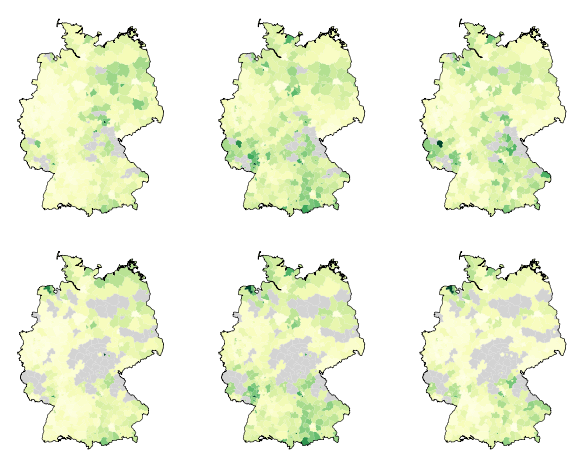

In [36]:
figure, axis = plt.subplots(2, 3)

gdf_germany_counties.plot(column='qol_rent_no_qualification', ax=axis[0,0], cmap='YlGn', 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"})
gdf_germany_counties.plot(column='qol_rent_professional', ax=axis[0,1], cmap='YlGn', 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"})
gdf_germany_counties.plot(column='qol_rent_academic', ax=axis[0,2], cmap='YlGn', 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"})
gdf_germany_counties.dissolve().plot(facecolor="none", edgecolor="black", linewidth=0.4, ax=axis[0,0])
gdf_germany_counties.dissolve().plot(facecolor="none", edgecolor="black", linewidth=0.4, ax=axis[0,1])
gdf_germany_counties.dissolve().plot(facecolor="none", edgecolor="black", linewidth=0.4, ax=axis[0,2])

gdf_germany_counties.plot(column='qol_purchase_no_qualification', ax=axis[1,0], cmap='YlGn', 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"})
gdf_germany_counties.plot(column='qol_purchase_professional', ax=axis[1,1], cmap='YlGn', 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"})
gdf_germany_counties.plot(column='qol_purchase_academic', ax=axis[1,2], cmap='YlGn', 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"})
gdf_germany_counties.dissolve().plot(facecolor="none", edgecolor="black", linewidth=0.4, ax=axis[1,0])
gdf_germany_counties.dissolve().plot(facecolor="none", edgecolor="black", linewidth=0.4, ax=axis[1,1])
gdf_germany_counties.dissolve().plot(facecolor="none", edgecolor="black", linewidth=0.4, ax=axis[1,2])

axis[0,0].set_axis_off()
axis[0,1].set_axis_off()
axis[0,2].set_axis_off()
axis[1,0].set_axis_off()
axis[1,1].set_axis_off()
axis[1,2].set_axis_off()

figure.tight_layout()

---

### (b) Fundamental productivity

$$
log(w_c) = \Omega_1 + \frac{log(A_c)}{1−\beta} − \frac{1−\alpha−\beta}{1−\beta} log(L_c) + \frac{1−\alpha−\beta}{1−\beta} log(Z)
$$

$$
log(A_c) = (log(w_c) - \Omega_1) (1−\beta) + (1−\alpha−\beta) log(L_c) - (1−\alpha−\beta) log(Z)
$$

Asumme $\alpha=\frac{2}{3}$.

$$
log(A_c) = (log(w_c) - \Omega_1) (1−\beta) + (1−\alpha−\beta) log(L_c) - (1−\alpha−\beta) log(Z)
$$

In [37]:
gdf_germany_counties['wage_average'] = (
    gdf_germany_counties['wage_no_qualification'] * gdf_germany_counties['workers_no_qualification'] + 
    gdf_germany_counties['wage_professional'] * gdf_germany_counties['workers_professional'] + 
    gdf_germany_counties['wage_academic'] * gdf_germany_counties['workers_academic']) / (
        gdf_germany_counties['workers_no_qualification'] + 
        gdf_germany_counties['workers_professional'] + 
        gdf_germany_counties['workers_academic'])

In [38]:
alpha = 2/3

gdf_germany_counties['workers'] = (
        gdf_germany_counties['workers_no_qualification'] + 
        gdf_germany_counties['workers_professional'] + 
        gdf_germany_counties['workers_academic'])

gdf_germany_counties['productivity_index'] = np.exp(gdf_germany_counties['wage_average'] / gdf_germany_counties['workers']** alpha)

In [39]:
## Good Solution
## See slide 32 

import statsmodels.api as sm

data_regression = gdf_germany_counties[['wage_average', 'workers']].dropna()

X = sm.add_constant(np.log(data_regression['wage_average']))
y = np.log(data_regression['workers'])

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                workers   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     132.3
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           1.37e-26
Time:                        17:01:08   Log-Likelihood:                -376.29
No. Observations:                 396   AIC:                             756.6
Df Residuals:                     394   BIC:                             764.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -13.3678      2.075     -6.441   

In [40]:
gdf_germany_counties['productivity_index'] = np.exp(
    (y - model.params[0] + model.params[1] * np.log(data_regression['wage_average']) ) / model.params[1] 
)

In [41]:
gdf_germany_counties.sort_values('productivity_index', ascending=False)[['county_name']].reset_index(drop=True).head(10)

,county_name
0,München
1,Berlin
2,Hamburg
3,Frankfurt am Main
4,Stuttgart
5,Köln
6,Düsseldorf
7,München
8,Region Hannover
9,Böblingen


In [42]:
#gdf_germany_counties['productivity_index'] = np.exp( model.resid / model.params[1] * (1-alpha) * (-1) )

#gdf_germany_counties['productivity_index'] = (gdf_germany_counties['productivity_index']-gdf_germany_counties['productivity_index'].min())/(gdf_germany_counties['productivity_index'].max()-gdf_germany_counties['productivity_index'].min())

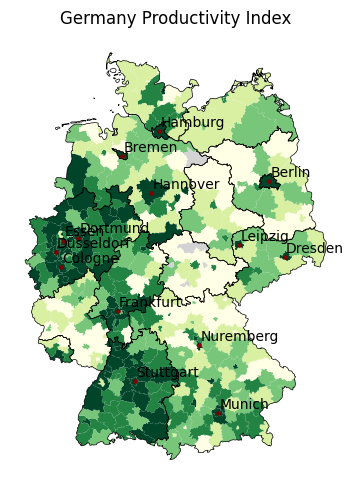

In [43]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5)) 

gdf_germany_counties.plot(column='productivity_index', cmap='YlGn',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          scheme="quantiles", legend=False, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          ncol=1))

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Germany Productivity Index')

plt.tight_layout()

---

### (c) Effective land supply

Create a theory-consistent measure of effective land supply, $M_c$. Assume a height elasticity of construction cost of 1.5. Map the land supply measure and discuss the spatial pattern. Bonus question: Can you think of a theory-consistent way of estimating the height elasticity of construction cost?


$$
log(P_c) = \Omega_2 + \frac{\delta - 1}{\delta} [log(w_c) + log(L_c) − log(M_c)]
$$

$$
log(M_c) = log(w_c) + log(L_c) - \frac{\delta}{\delta-1} [log(P_c) - \Omega_2]
$$

$$
M_c = \frac{w_c L_c}{P_c^{\frac{\delta}{\delta-1}}} * \exp(\frac{\delta}{\delta-1} \Omega_2)
$$

where $\frac{\delta}{\delta-1}$ is defined as $\epsilon$, the height elasticity of construction cost.

---

In [58]:
delta = 1.5

gdf_germany_counties['effective_land_supply'] = np.exp(
    np.log(gdf_germany_counties['wage_average']) + np.log(gdf_germany_counties['workers']) - np.log(gdf_germany_counties['rent_index']) ** (delta/(delta-1))
)

/Users/dominik.bursy/opt/anaconda3/envs/firefighter/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [59]:
gdf_germany_counties.sort_values('effective_land_supply', ascending=False)[['county_name']].reset_index(drop=True).head(10)

,county_name
0,Vogtlandkreis
1,Saale-Holzland-Kreis
2,Spree-Neiße
3,Chemnitz
4,Erzgebirgskreis
5,Greiz
6,Altenburger Land
7,Zwickau
8,Gera
9,Mittelsachsen


/Users/dominik.bursy/opt/anaconda3/envs/firefighter/lib/python3.9/site-packages/mapclassify/classifiers.py:940: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/Users/dominik.bursy/opt/anaconda3/envs/firefighter/lib/python3.9/site-packages/mapclassify/classifiers.py:970: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


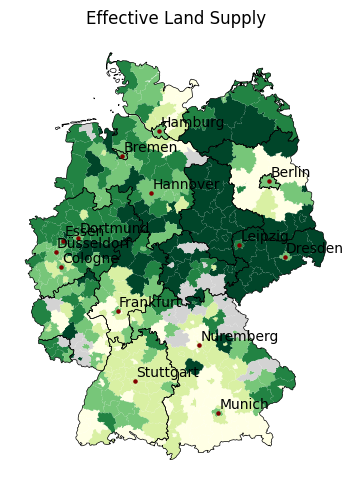

In [60]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5)) 

gdf_germany_counties.plot(column='effective_land_supply', cmap='YlGn',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          scheme="quantiles", legend=False, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          ncol=1))

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Effective Land Supply')

plt.tight_layout()

#### Alternative

$$
M_c = \frac{(L_c / Area_c) ^ \epsilon }{P_c} = \frac{(Density_c) ^ \epsilon }{P_c}
$$

In [47]:
epsilon = 1.5

gdf_germany_counties['density'] = gdf_germany_counties['workers'] / gdf_germany_counties['county_area'] / 1e6
# gdf_germany_counties['M_c'] = (gdf_germany_counties['density'] ** epsilon) / gdf_germany_counties['rent_index']

gdf_germany_counties['effective_land_supply'] = (gdf_germany_counties['density'] ** epsilon) / gdf_germany_counties['rent_index']

/Users/dominik.bursy/opt/anaconda3/envs/firefighter/lib/python3.9/site-packages/mapclassify/classifiers.py:940: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/Users/dominik.bursy/opt/anaconda3/envs/firefighter/lib/python3.9/site-packages/mapclassify/classifiers.py:970: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


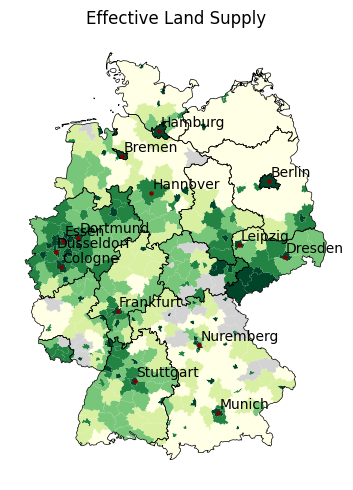

In [48]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5)) 

gdf_germany_counties.plot(column='effective_land_supply', cmap='YlGn',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          scheme="quantiles", legend=False, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          ncol=1))

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Effective Land Supply')

plt.tight_layout()

In [49]:
# from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler().fit_transform(gdf_germany_counties[['rent_index']])

Bonus question: Can you think of a theory-consistent way of estimating the height elasticity of construction cost?

In [50]:
import statsmodels.api as sm

gdf_germany_counties['rent_index'] = (gdf_germany_counties['rent_index']-gdf_germany_counties['rent_index'].min())/(gdf_germany_counties['rent_index'].max()-gdf_germany_counties['rent_index'].min())

# log(Rent) = constant + ε * log(Density) + u
X = sm.add_constant(np.log(gdf_germany_counties[['density', 'rent_index']]).replace([np.inf, -np.inf], np.nan).dropna())
y = X.pop('rent_index')

model = sm.OLS(y, X).fit()
print(model.summary())

estimated_epsilon = model.params['density']

                            OLS Regression Results                            
Dep. Variable:             rent_index   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     54.39
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           1.06e-12
Time:                        17:02:25   Log-Likelihood:                -432.79
No. Observations:                 378   AIC:                             869.6
Df Residuals:                     376   BIC:                             877.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5385      0.296      1.817      0.0

/Users/dominik.bursy/opt/anaconda3/envs/firefighter/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


---

Discussion Points for Spatial Pattern
After plotting, here’s what to look for:

- Urban counties (e.g., Berlin, Munich) likely have low M_c → high prices, dense development
- Rural counties may show higher M_c → abundant land, lower prices
- Topographic constraints (e.g., in Alpine regions) may show artificially low land supply
- Eastern vs. Western Germany: any structural differences?

---

## Appendix <a class="anchor" id="appendix"></a>

In [ ]:
## CODE HERE

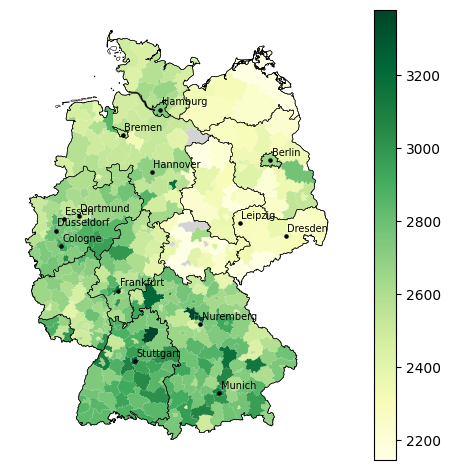

In [ ]:
df_cities = pd.read_csv('https://simplemaps.com/static/data/country-cities/de/de.csv')

gdf_cities = gpd.GeoDataFrame(
    df_cities, geometry=gpd.points_from_xy(df_cities.lng, df_cities.lat), crs="EPSG:4326"
).to_crs(25832)
f
gdf_cities = gdf_cities.iloc[:14,:]

figure, axis = plt.subplots(1, 1)

gdf_germany_counties.plot(column='wage_no_qualification', ax=axis, cmap='YlGn', legend=True, #scheme="quantiles", 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}) # cmap='RdYlGn'
gdf_germany_counties.dissolve().plot(facecolor="none", edgecolor="black", linewidth=0.4, ax=axis)
gpd.read_file('/Users/dominik.bursy/Downloads/vg2500_12-31.utm32s.shape/vg2500/VG2500_LAN.shp').iloc[:16].plot(facecolor="none", edgecolor="black", linewidth=0.4, ax=axis)
plt.axis('off')
gdf_cities.plot(marker='o', color='black', markersize=5, ax=axis)
axis.set_axis_off()
# figure.suptitle('Wages in Germany across Skill Groups')
# axis[0].set_title("Sine Function")
for x, y, label in zip(gdf_cities.geometry.x, gdf_cities.geometry.y, gdf_cities.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords="offset points", fontsize=7)

plt.tight_layout()

In [ ]:
# https://gdz.bkg.bund.de/index.php/default/digitale-geodaten/verwaltungsgebiete/verwaltungsgebiete-1-2-500-000-stand-31-12-vg2500-12-31.html
#gpd.read_file('zip://daten.gdz.bkg.bund.de/produkte/vg/vg2500/aktuell/vg2500_12-31.utm32s.shape.zip')

import requests, zipfile, io

url = 'https://daten.gdz.bkg.bund.de/produkte/vg/vg2500/aktuell/vg2500_12-31.utm32s.shape.zip'
filename = 'vg2500_12-31.utm32s.shape/vg2500/VG2500_LAN.shp'

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

import pandas as pd
gpd.read_file(filename, sep=',')

,OBJID,BEGINN,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,...,SN_K,SN_V1,SN_V2,SN_G,FK_S3,NUTS,ARS_0,AGS_0,WSK,geometry
0,DEBKGVG3000000BP,2023-12-31,2,9,1,01,01,010020000000,Schleswig-Holstein,Land,...,00,00,00,000,0,DEF,010000000000,01000000,2012-02-01,"MULTIPOLYGON (((481497.840 6058956.676, 479442..."
1,DEBKGVG3000000BQ,2021-09-01,2,9,1,02,02,020000000000,Hamburg,Freie und Hansestadt,...,00,00,00,000,0,DE6,020000000000,02000000,1974-01-01,"MULTIPOLYGON (((463107.577 5977587.614, 462620..."
2,DEBKGVG3000000BR,2021-09-01,2,9,1,03,03,032410001001,Niedersachsen,Land,...,00,00,00,000,0,DE9,030000000000,03000000,2015-01-01,"MULTIPOLYGON (((361738.604 5946370.067, 360081..."
3,DEBKGVG3000000BS,2021-09-01,2,9,1,04,04,040110000000,Bremen,Freie Hansestadt,...,00,00,00,000,0,DE5,040000000000,04000000,2010-01-01,"MULTIPOLYGON (((471632.562 5939100.928, 473112..."
4,DEBKGVG3000000BT,2021-09-01,2,9,1,05,05,051110000000,Nordrhein-Westfalen,Land,...,00,00,00,000,0,DEA,050000000000,05000000,2009-11-01,"POLYGON ((477387.557 5819094.537, 479831.350 5..."
5,DEBKGVG3000000BU,2021-09-01,2,9,1,06,06,064140000000,Hessen,Land,...,00,00,00,000,0,DE7,060000000000,06000000,2015-01-01,"POLYGON ((534996.688 5719759.636, 535192.268 5..."
6,DEBKGVG3000000BV,2021-09-01,2,9,1,07,07,073150000000,Rheinland-Pfalz,Land,...,00,00,00,000,0,DEB,070000000000,07000000,2004-01-01,"POLYGON ((418854.535 5636959.218, 419727.432 5..."
7,DEBKGVG3000000BW,2021-09-01,2,9,1,08,08,081110000000,Baden-Württemberg,Land,...,00,00,00,000,0,DE1,080000000000,08000000,1997-01-01,"MULTIPOLYGON (((475219.827 5281413.364, 474909..."
8,DEBKGVG3000000BX,2021-09-01,2,9,1,09,09,091620000000,Bayern,Freistaat,...,00,00,00,000,0,DE2,090000000000,09000000,2011-07-01,"POLYGON ((609432.033 5267963.452, 608342.805 5..."
9,DEBKGVG3000000BY,2021-09-01,2,9,1,10,10,100410100100,Saarland,Land,...,00,00,00,000,0,DEC,100000000000,10000000,2009-01-01,"POLYGON ((360503.109 5498561.661, 361315.971 5..."


---

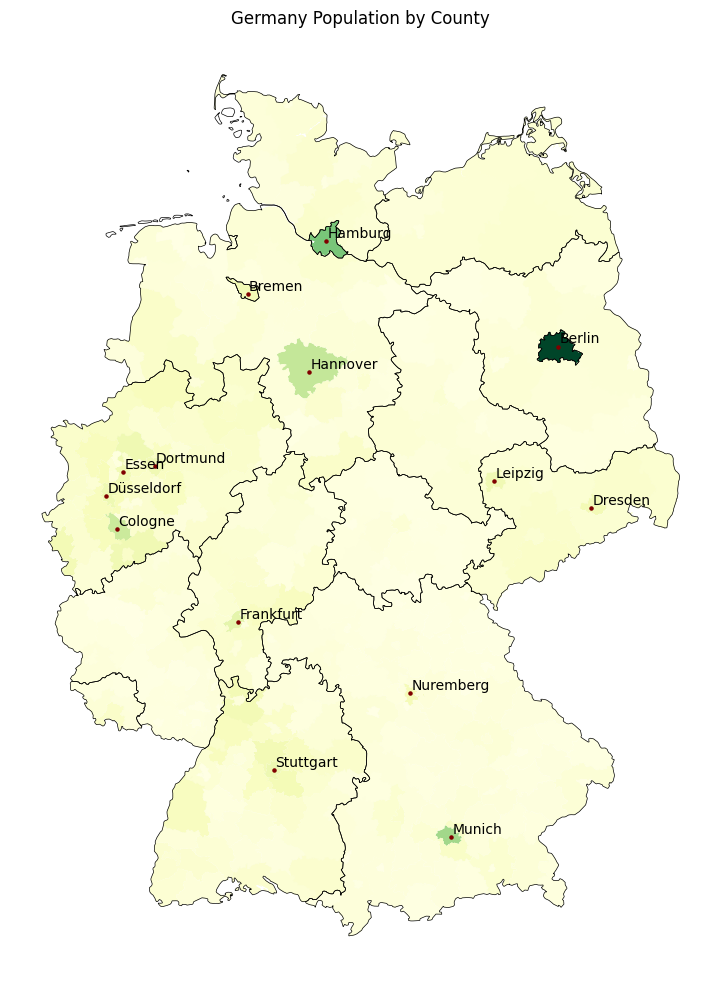

In [ ]:
figure, axis = plt.subplots(1, 1, figsize=(10, 10)) 

gdf_germany_counties.plot(column='population', cmap='YlGn',ax=axis)

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Germany Population by County')

plt.tight_layout()

---